# Objectives

1. Plot RTT: Regression
1. Plot Rate Variation: Histogram
1. Plot Timetree: Phylo
1. Plot Divtree: Phylo
1. Plot Marginal Distribution: Violin

---
# Setup

## Import Modules

In [73]:
import os
import copy

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

import dill
from treetime.treetime import plot_vs_years

## Input File Paths

In [2]:
# jupyter notebook output
tree_df_dill = "../../results/clock_model/clock_model.df.obj"
tree_dill = "../../results/clock_model/clock_model.treetime.obj"
augur_json = "../../results/clock_model/clock_model_augur.json"

outdir = "../../results/clock_model/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

## Import Dataframe

In [4]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)

## Import Tree

In [5]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

In [6]:
tt.clock_model

{'slope': 1.0144711885313445e-08,
 'intercept': 4.500306099077243e-05,
 'chisq': 419.4894792263442,
 'hessian': array([[2.88889202e+18, 1.75969471e+14],
        [1.75969471e+14, 2.32685031e+11]]),
 'cov': array([[ 3.62869188e-19, -2.74422033e-16],
        [-2.74422033e-16,  4.50518840e-12]]),
 'r_val': 0.49983685801723704,
 'valid_confidence': True}

---
# 1. Plot RTT: Regression

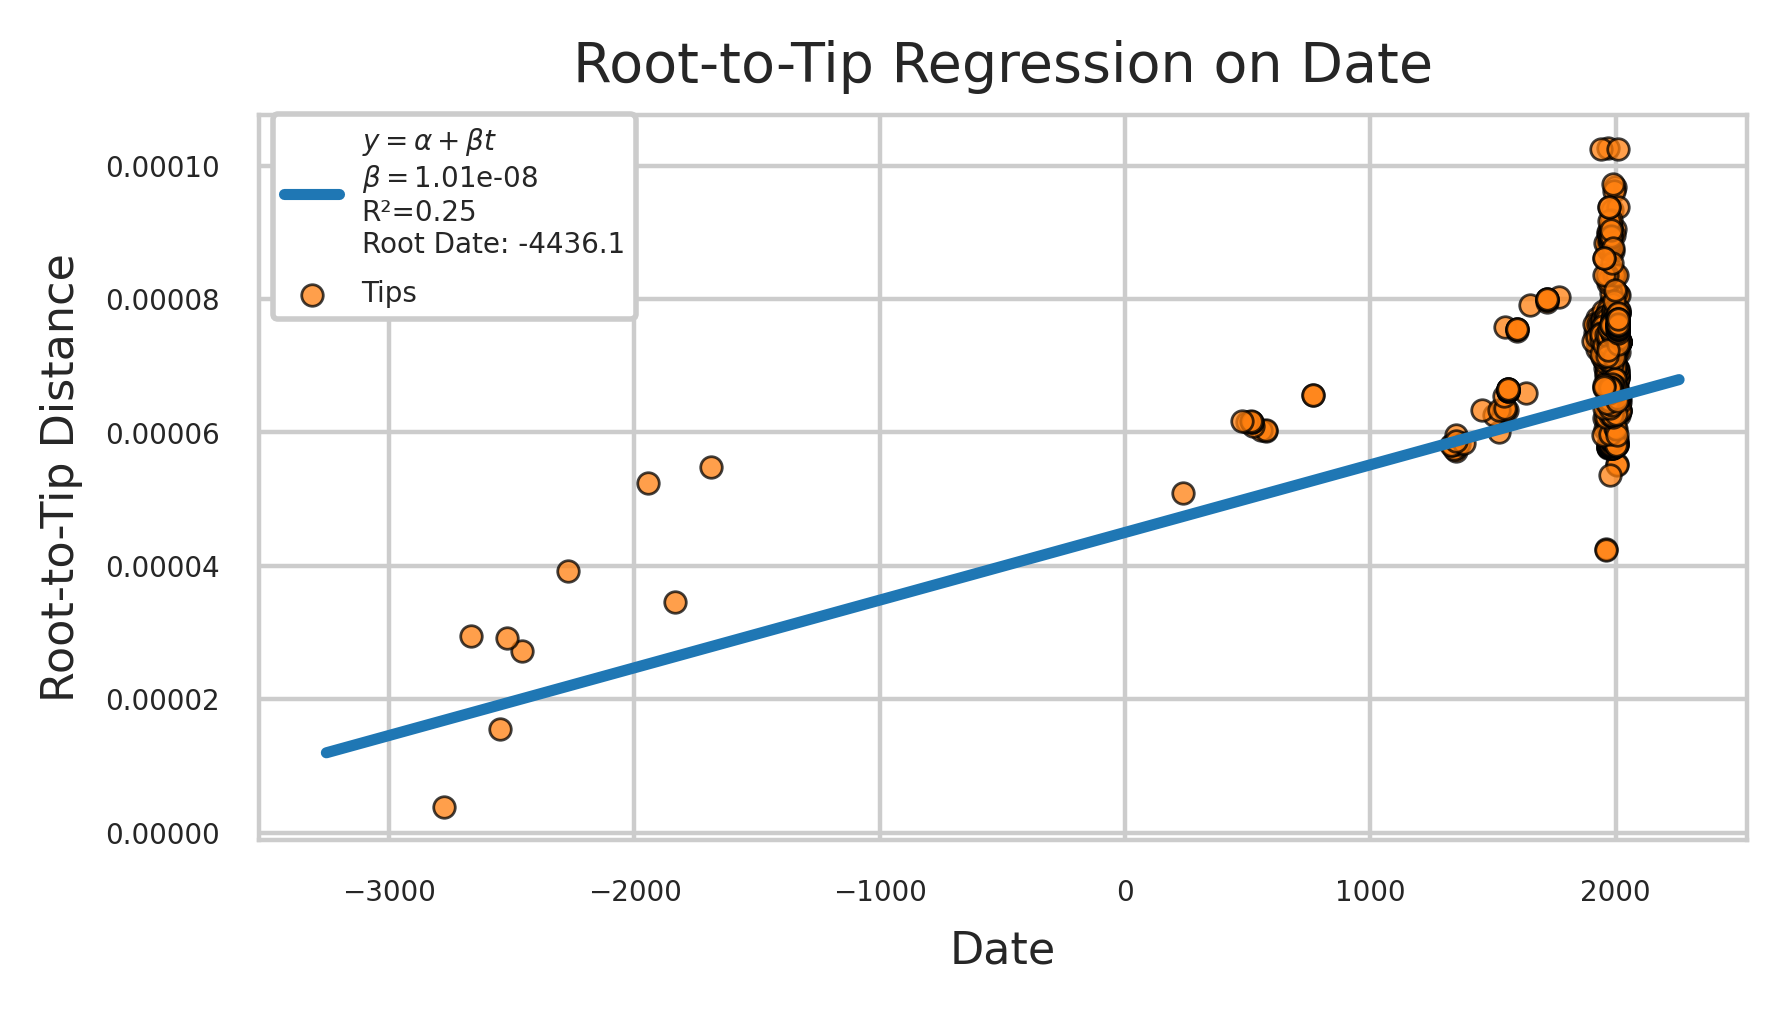

In [48]:
regression = tt.clock_model

# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
"""ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)"""
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.2f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
#plt.legend(loc=2, frameon = 1, framealpha=1)
plt.legend(bbox_to_anchor=(0,1.02), 
           loc="upper left",
           frameon = 1, 
           framealpha=1)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation: Histogram

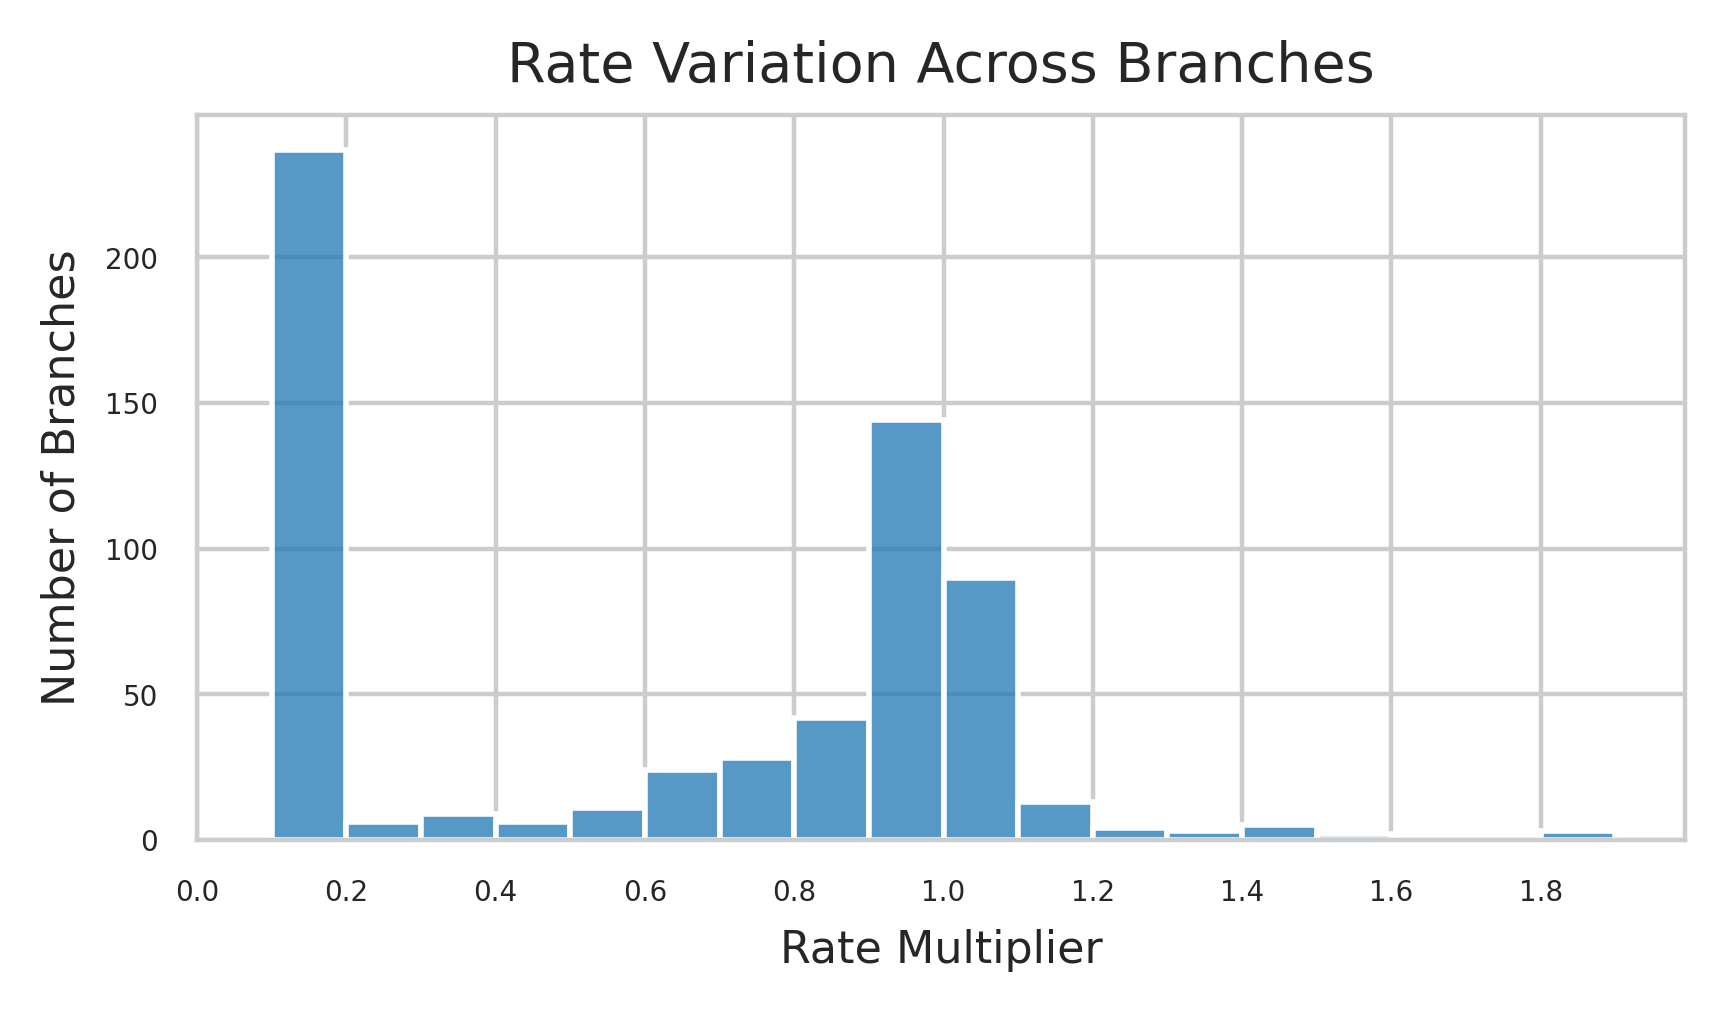

In [49]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the histogram
# troubleshoot the disappearing nodes!

min_gamma = ['', 1]
max_gamma = ['', 1]
gamma_dict = {}
    
for rec in tip_data.iterrows():
    sample = rec[0]
    data = rec[1]
    g = tip_data["timetree_rate_fold_change"][sample]
    if g <= min_gamma[1]:
        min_gamma[0] = sample
        min_gamma[1] = g
    if g >= max_gamma[1]:
        max_gamma[0] = sample
        max_gamma[1] = g
    gamma_dict[sample] = g

# Check if there's no rate variation
if min_gamma[1] == 1 and max_gamma[1] == 1:
    hist_bins=1
    ax1.set_xticks([1.0])
else:
    int_max_gamma = math.ceil(max_gamma[1])
    hist_bins = [x/10 for x in range(0,int_max_gamma * 10, 1)]
    xticks_major = [x/10 for x in range(0, int_max_gamma * 10, 2)]
    ax1.set_xticks(xticks_major)
    ax1.set_xlim(0,max_gamma[1])

sns.histplot(x = list(gamma_dict.values()), 
         ax=ax1,
         alpha=0.75,
         bins=hist_bins,
         ) 

ax1.set_xlabel("Rate Multiplier")
ax1.set_ylabel("Number of Branches")
ax1.set_title("Rate Variation Across Branches")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate-variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")

# 3. Plot Timetree: Phylo

4444.03	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


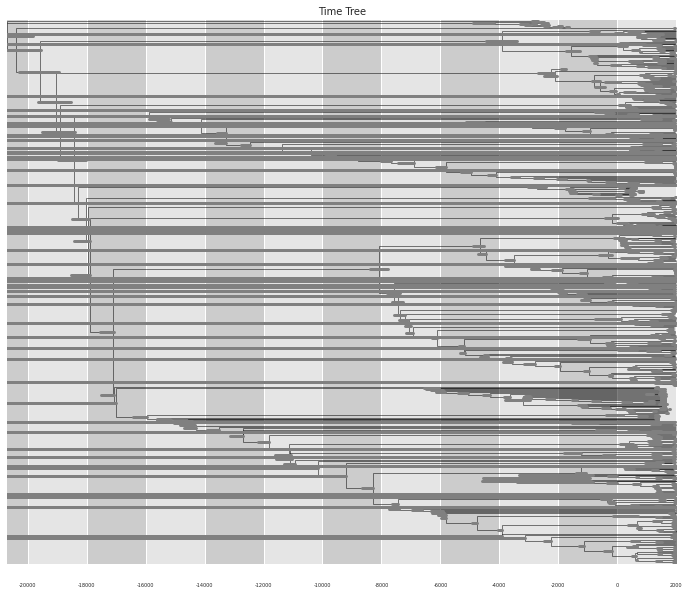

In [82]:
tt_copy = copy.deepcopy(tt)

# Setup plot
plt.rc("lines", linewidth=0.5)
DIV = 10
STEP = (CURRENT_YEAR - tt_copy.tree.root.numdate) / DIV
STEP = round(STEP, -3)

fig, ax1 = plot_vs_years(tt_copy,
                         step=STEP,  
                         confidence=(0.05,0.95), 
                         label_func = lambda x:"",
                         do_show=False)

ax1.set_title("Time Tree")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")


# 4. Plot Divtree: Phylo

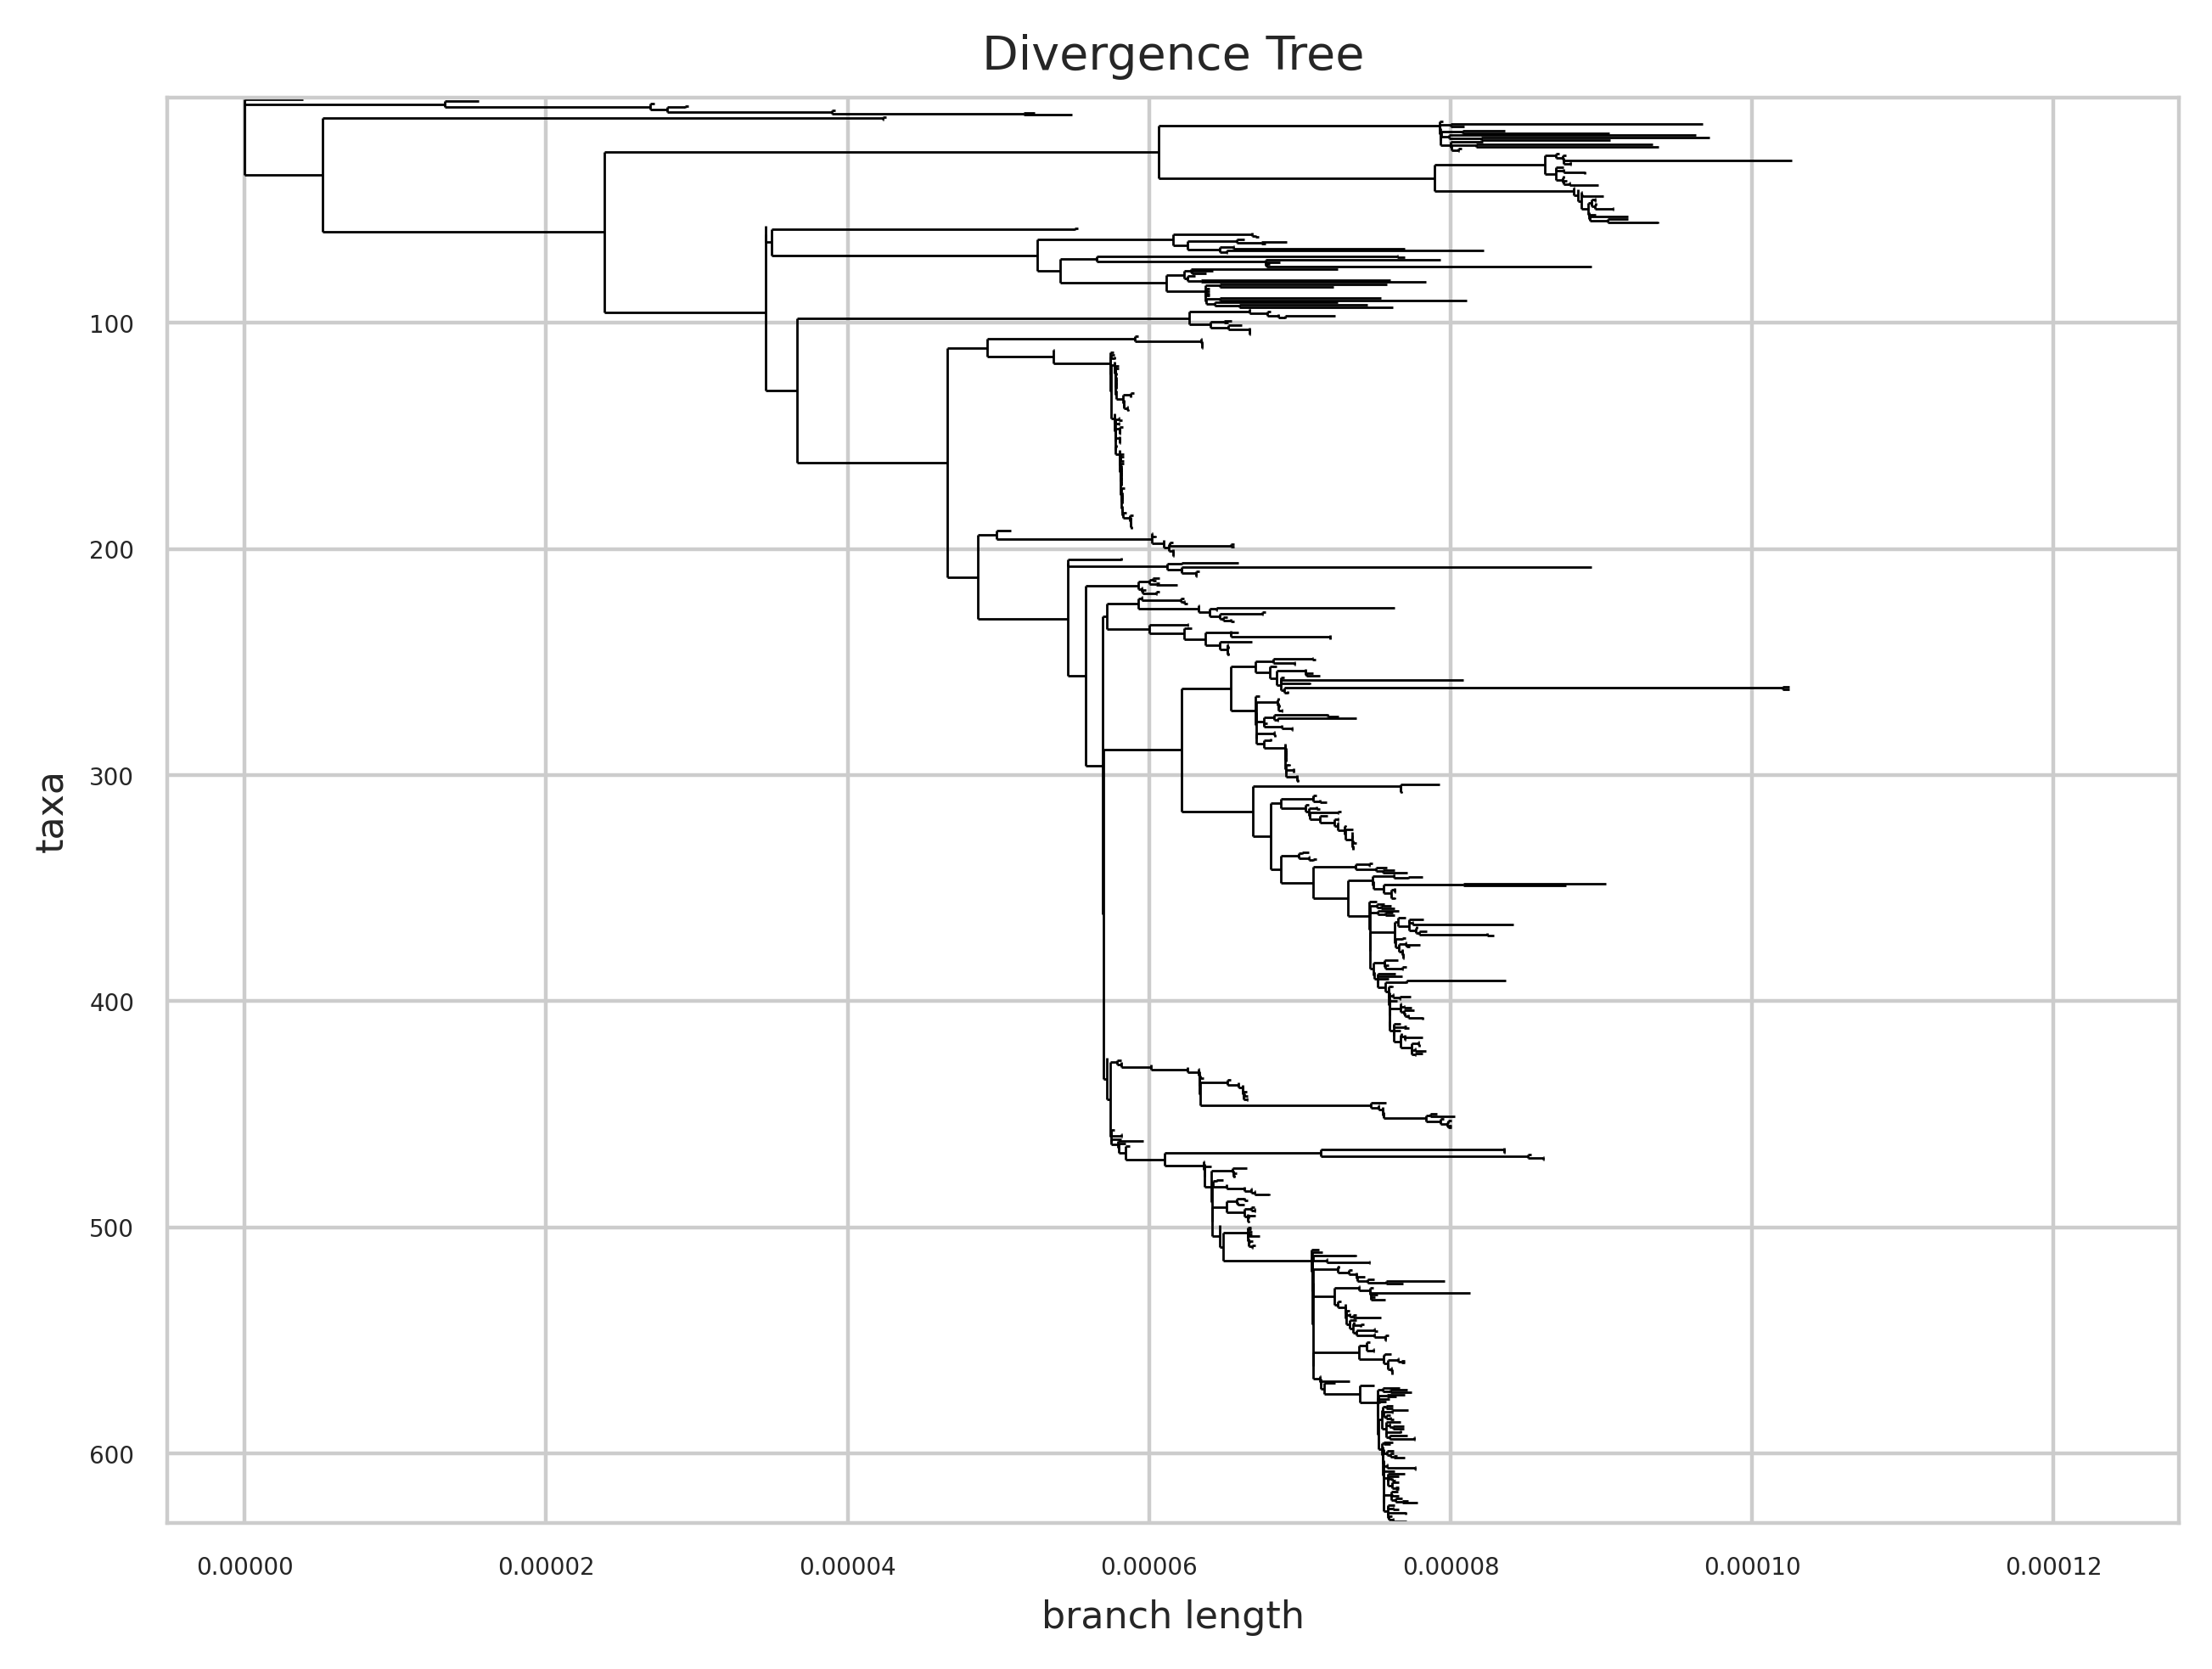

In [62]:
# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Setup plot
plt.rc("lines", linewidth=0.5)
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)
    
Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

ax1.set_title("Divergence Tree")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")